In [4]:
%reload_ext autoreload
%autoreload 2
%reload_ext ipy_dict_hierarchy
%reload_ext watermark

import logging
logging.basicConfig(
    format="%(asctime)s | %(levelname)-8s | %(name)-s | %(funcName)-s | %(message)s",
    level=logging.WARNING,
)
log = logging.getLogger("notebook")
log.setLevel("DEBUG")

import re
import glob
import h5py
import sys
import os
import numpy as np
import xarray as xr
import pandas as pd
import dask
import seaborn as sns

import matplotlib.pyplot as plt
from tqdm import tqdm
from bitsandbobs.plt import set_size
import matplotlib as mpl

# also needs to be added for each dask-worker
extra_path = os.path.abspath('../')
sys.path.append(extra_path)
log.info(f"project directory: {extra_path}")

from ana import utility as utl
from ana import plot_helper as ph

ph.log.setLevel("DEBUG")
utl.log.setLevel("DEBUG")

data_dir = os.path.abspath("/path/to/repo/experiment_analysis/dat/")
data_dir = "../../../paper_code/experiment_analysis/data/"
os.makedirs("../img/", exist_ok=True)

2024-07-11 07:29:42,901 | INFO     | notebook | <module> | project directory: /data.nst/lucas/projects/mouse_visual_timescales_predictability/paper_code_repo/experiment_analysis


In [2]:
# Load and preprocess analysis results
meta_df = pd.read_hdf(
    f"{data_dir}/all_units_merged_blocks_with_spont.h5", key="meta_df"
)

# add metrics from image selectivity etc.
meta_df = utl.load_metrics(meta_df.reset_index(), data_dir)
meta_df = utl.add_structure_and_hierarchy_scores(meta_df)
df = meta_df.query("stimulus == 'natural_movie_three'")

# sanity check, selectivity should be present for all units in natural_movie_three
assert (
    len(meta_df.query("stimulus == 'natural_movie_three'"))
    == np.isfinite(
        meta_df.query("stimulus == 'natural_movie_three'")["mod_idx_dg"]
    ).sum()
)

# exclude nans for now ~ 5 rows with low rates and one todo for unit 951021415
len_before = len(meta_df)
meta_df = meta_df.query("R_tot == R_tot")
meta_df = meta_df.query("tau_R > 0.0")
meta_df = meta_df.query("tau_double > 0.0 & tau_double < 10.0")
# timescales above 10s are likely an inference problems,
# as we have 600 - 800 seconds of data. cf. https://arxiv.org/abs/2007.03367
len_after = len(meta_df)
log.info(f"removed {len_before - len_after} rows due to unexpected timescales")

2024-07-11 07:23:54,993 | DEBUG    | its_utility | load_metrics | Loaded columns ['unit_id', 'g_dsi_dg', 'mod_idx_dg', 'on_screen_rf', 'image_selectivity_ns'] from /data.nst/lucas/projects/mouse_visual_timescales_predictability/paper_code/experiment_analysis/data/brain_observatory_unit_metrics_filtered.csv
2024-07-11 07:23:54,995 | DEBUG    | its_utility | load_metrics | Matched 6368 rows from meta_df in /data.nst/lucas/projects/mouse_visual_timescales_predictability/paper_code/experiment_analysis/data/brain_observatory_unit_metrics_filtered.csv
2024-07-11 07:24:04,036 | INFO     | notebook | <module> | removed 1163 rows due to unexpected timescales


2024-07-11 07:29:49,548 | INFO     | plot_helper | panel_selectivity_scatter | dropped 2056 rows with nan
2024-07-11 07:29:49,554 | INFO     | plot_helper | panel_selectivity_scatter | r: -0.225, p: 1.1e-15, m: -807.694, b: 966.027
2024-07-11 07:29:49,568 | INFO     | plot_helper | panel_selectivity_scatter | dropped 2056 rows with nan
2024-07-11 07:29:49,572 | INFO     | plot_helper | panel_selectivity_scatter | r: -0.063, p: 0.027, m: -12.536, b: 67.853
2024-07-11 07:29:49,583 | INFO     | plot_helper | panel_selectivity_scatter | dropped 2056 rows with nan
2024-07-11 07:29:49,588 | INFO     | plot_helper | panel_selectivity_scatter | r: 0.407, p: 1.8e-50, m: 0.089, b: 0.049
2024-07-11 07:29:49,600 | INFO     | plot_helper | panel_selectivity_scatter | dropped 1404 rows with nan
2024-07-11 07:29:49,604 | INFO     | plot_helper | panel_selectivity_scatter | r: -0.281, p: 1.2e-10, m: -1406.777, b: 1396.742
2024-07-11 07:29:49,616 | INFO     | plot_helper | panel_selectivity_scatter | d

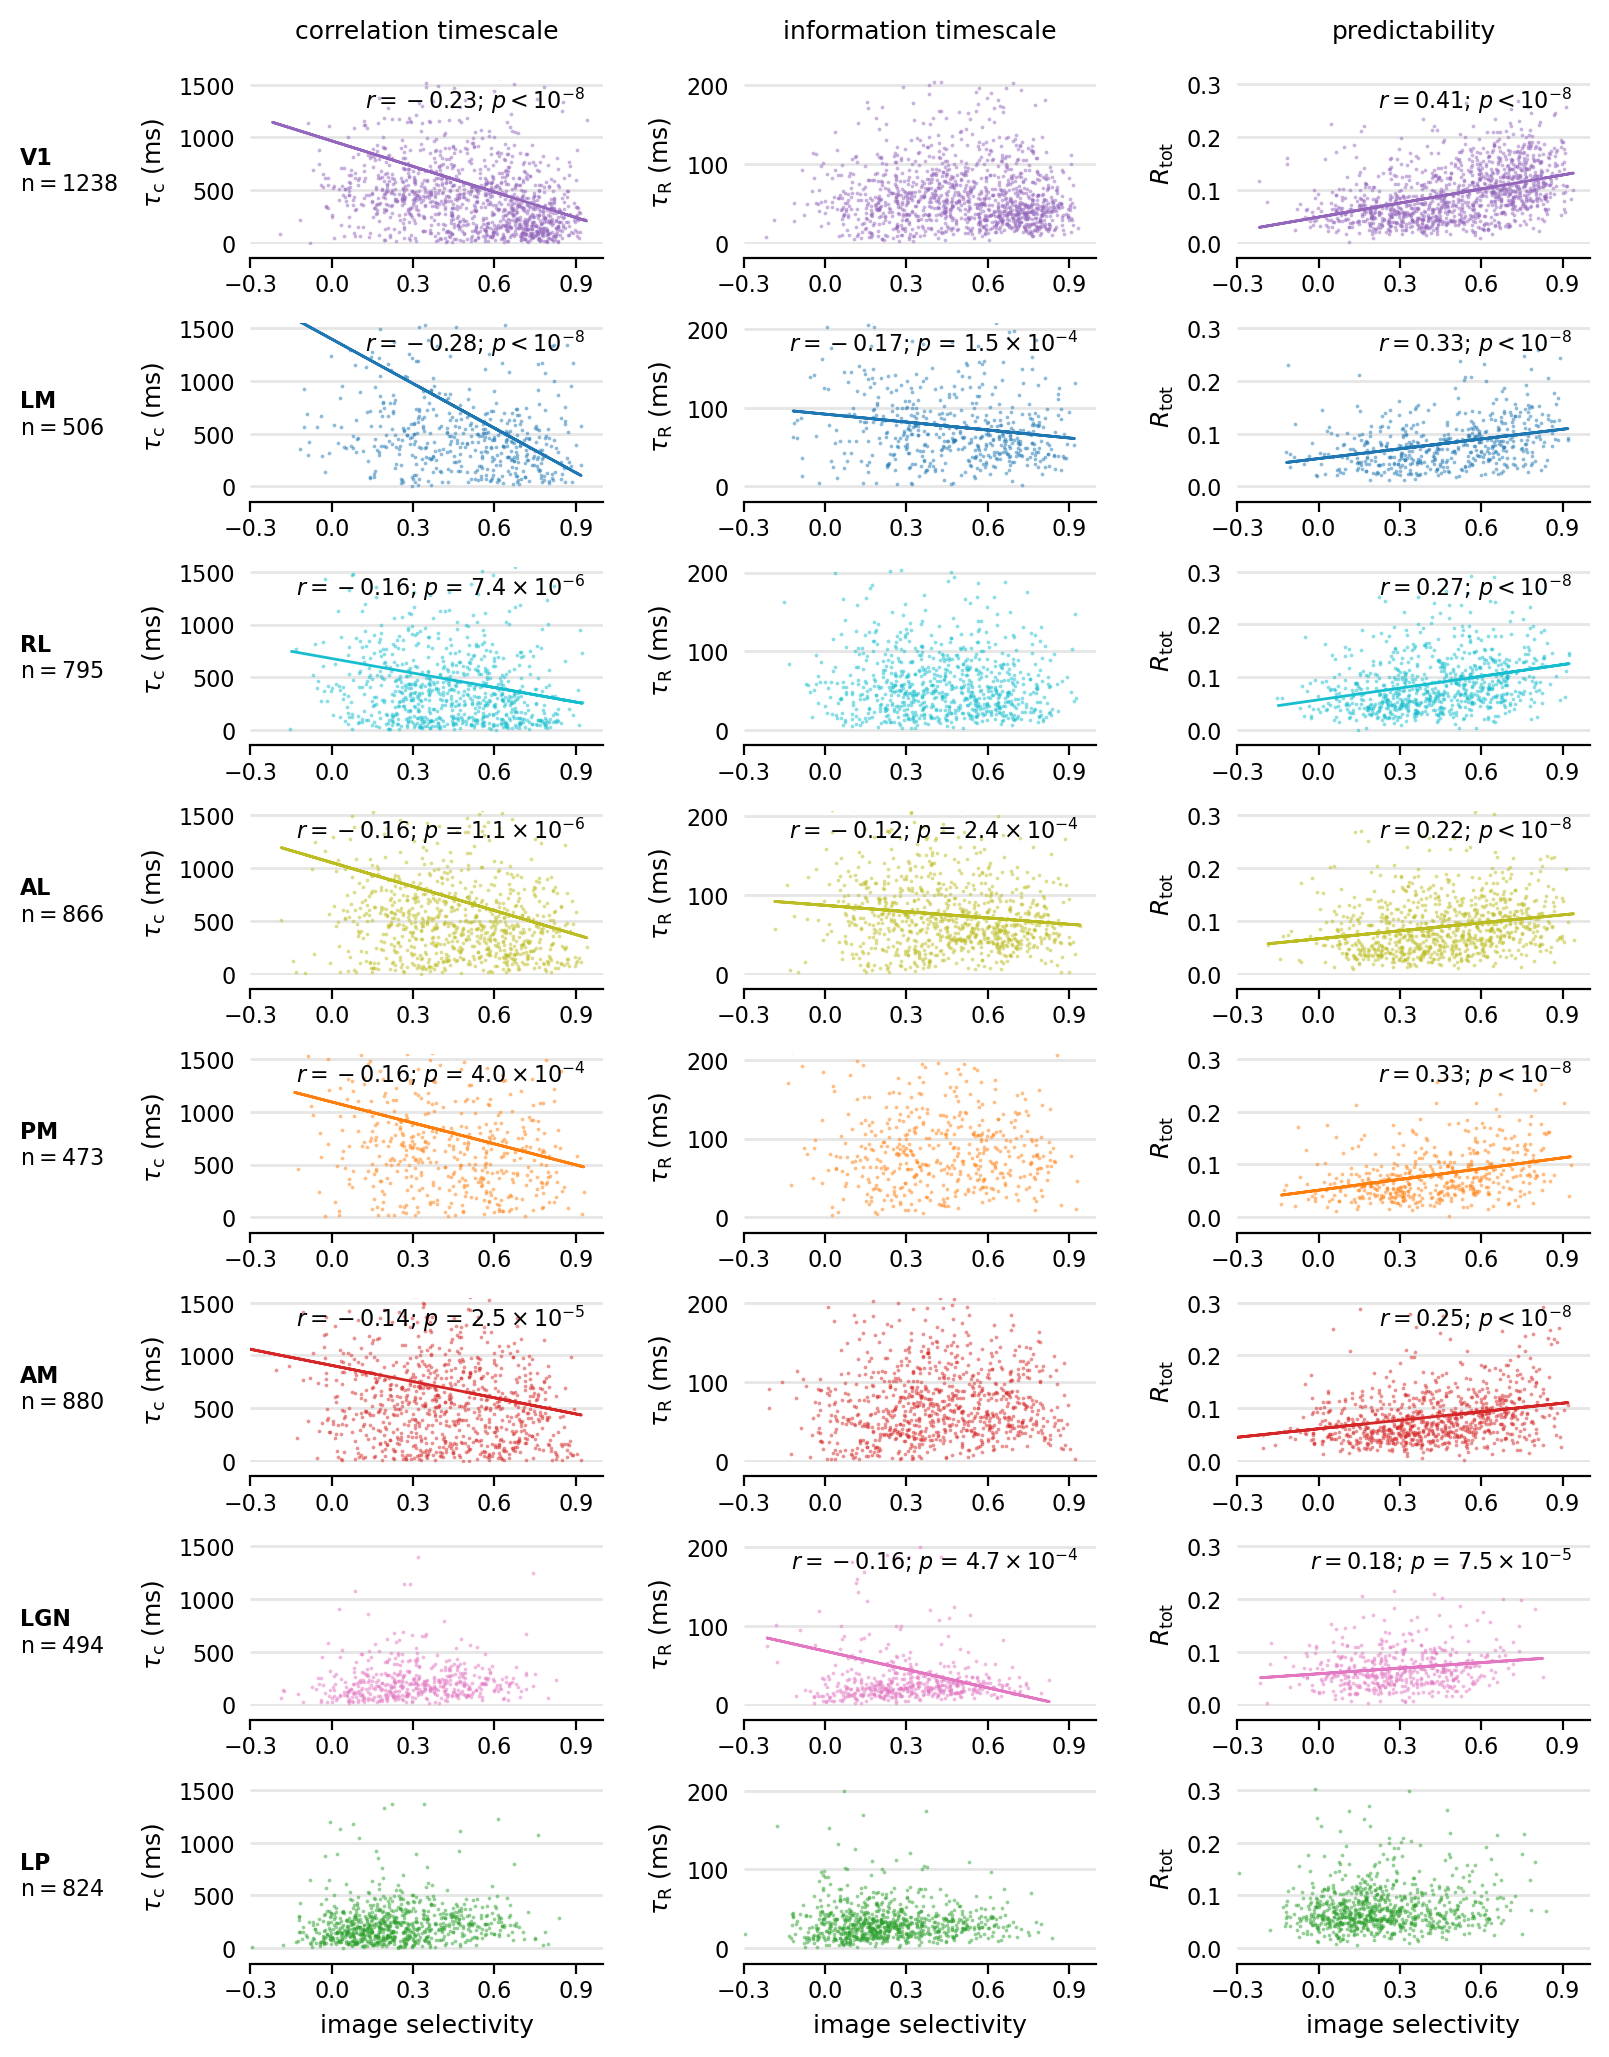

In [5]:
# Plot image selectivity for each area
selectivity_metric = "image_selectivity_ns"

plot_settings = {}
plot_settings["textwidth"] = 5.787402103

color_palette = sns.color_palette().as_hex()
hex_area_colors = [
    color_palette[4],
    color_palette[0],
    color_palette[9],
    color_palette[8],
    color_palette[1],
    color_palette[3],
    color_palette[6],
    color_palette[2],
]

areas = ["VISp", "VISl", "VISrl", "VISal", "VISpm", "VISam", "LGd", "LP"]
area_names = {
    "VISp": "V1",
    "VISl": "LM",
    "VISal": "AL",
    "VISpm": "PM",
    "VISam": "AM",
    "VISrl": "RL",
    "LGd": "LGN",
    "LP": "LP",
}
area_colors = {area: hex_area_colors[i] for i, area in enumerate(areas)}
observables = ["tau_double", "tau_R", "R_tot"]
plot_ylabel = False
plot_xlabel = False
plot_areaname = True

fig, axes = plt.subplots(8, 3, figsize=(1.3 * plot_settings["textwidth"], 11))
fig.subplots_adjust(left=0.01, right=0.9, top=0.95, bottom=0.1, wspace=0.4, hspace=0.48)

bonferroni_correction = 1 / (len(axes) * len(observables))

for i, rows in enumerate(axes):
    # this iterates over brain areas
    area = areas[i]
    area_name = area_names[area]
    color = hex_area_colors[i]
    kwargs = {
        "area_name": area_name,
        "x_text": -1.15,
        "bonferroni_correction": bonferroni_correction,
    }

    ax0 = rows[0]
    ax1 = rows[1]
    ax2 = rows[2]

    # Set subtitle
    if i == 0:
        ax0.set_title(
            r"correlation timescale", pad=15
        )  # , usetex = True, fontsize = 16)
        ax1.set_title(
            r"information timescale", pad=15
        )  # , usetex = True, fontsize = 16)
        ax2.set_title(r"predictability", pad=15)  # , usetex = True, fontsize = 16)

    if i == len(axes) - 1:
        plot_xlabel = True

    for ax, obs in zip([ax0, ax1, ax2], observables):
        # this iterates over the three observables
        with mpl.rc_context(
            {"xtick.labelsize": 8, "axes.labelsize": 8, "font.size": 8}
        ):
            ax = ph.panel_selectivity_scatter(
                df=meta_df.query("ecephys_structure_acronym == @area"),
                observable=obs,
                selectivity_metric=selectivity_metric,
                ax=ax,
                color=color,
                point_size=1.8,
                plot_xlabel=plot_xlabel,
                plot_ylabel=plot_ylabel,
                plot_areaname=plot_areaname,
                **kwargs,
            )
            #
# set_size(ax, w=4.0, h=2.1)
plt.savefig(
    f"../img/SI_scatter_bo_{selectivity_metric}_for_areas.pdf",
    bbox_inches="tight",
    dpi=600,
)
plt.show()
plt.close()

2024-07-11 07:30:10,374 | INFO     | plot_helper | panel_selectivity_scatter | dropped 2056 rows with nan
2024-07-11 07:30:10,378 | INFO     | plot_helper | panel_selectivity_scatter | r: -0.196, p: 3.1e-12, m: -1084.832, b: 723.075
2024-07-11 07:30:10,391 | INFO     | plot_helper | panel_selectivity_scatter | dropped 2056 rows with nan
2024-07-11 07:30:10,396 | INFO     | plot_helper | panel_selectivity_scatter | r: -0.202, p: 6.9e-13, m: -61.914, b: 71.017
2024-07-11 07:30:10,406 | INFO     | plot_helper | panel_selectivity_scatter | dropped 2056 rows with nan
2024-07-11 07:30:10,409 | INFO     | plot_helper | panel_selectivity_scatter | r: 0.389, p: 5.4e-46, m: 0.131, b: 0.074
2024-07-11 07:30:10,419 | INFO     | plot_helper | panel_selectivity_scatter | dropped 1404 rows with nan
2024-07-11 07:30:10,423 | INFO     | plot_helper | panel_selectivity_scatter | r: -0.165, p: 0.00019, m: -1700.304, b: 948.661
2024-07-11 07:30:10,436 | INFO     | plot_helper | panel_selectivity_scatter |

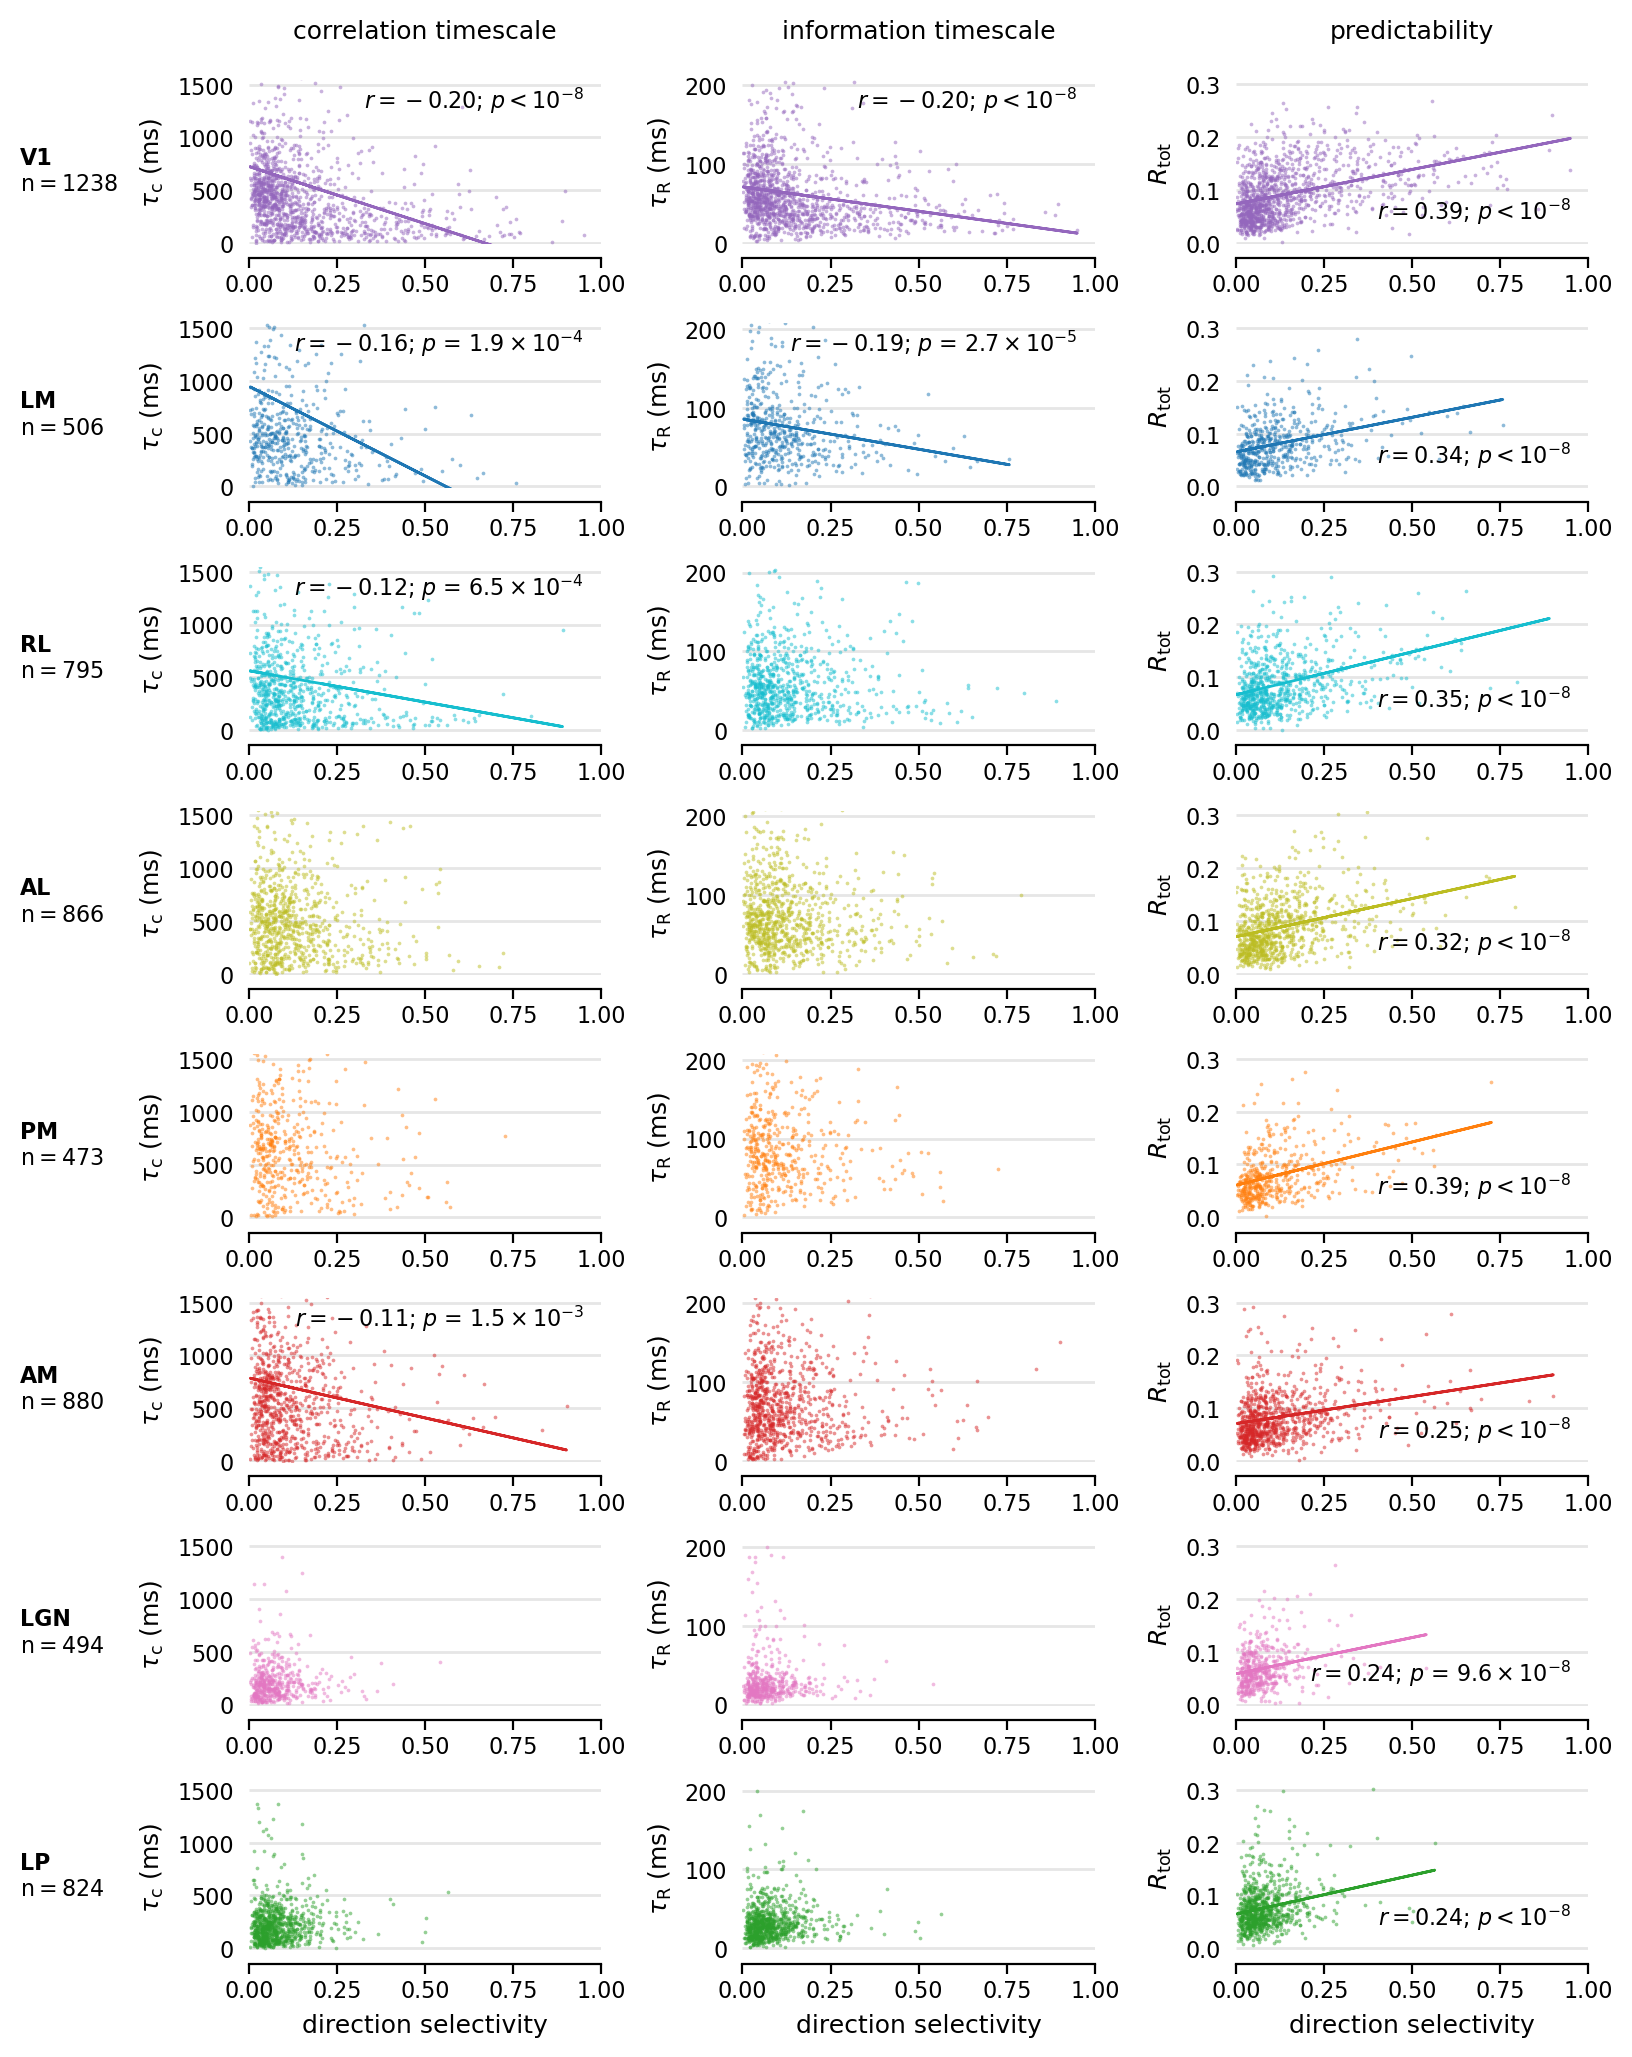

In [6]:
# Plot image selectivity for each area
selectivity_metric = "g_dsi_dg"

plot_settings = {}
plot_settings["textwidth"] = 5.787402103

color_palette = sns.color_palette().as_hex()
hex_area_colors = [
    color_palette[4],
    color_palette[0],
    color_palette[9],
    color_palette[8],
    color_palette[1],
    color_palette[3],
    color_palette[6],
    color_palette[2],
]

areas = ["VISp", "VISl", "VISrl", "VISal", "VISpm", "VISam", "LGd", "LP"]
area_names = {
    "VISp": "V1",
    "VISl": "LM",
    "VISal": "AL",
    "VISpm": "PM",
    "VISam": "AM",
    "VISrl": "RL",
    "LGd": "LGN",
    "LP": "LP",
}
area_colors = {area: hex_area_colors[i] for i, area in enumerate(areas)}
observables = ["tau_double", "tau_R", "R_tot"]
plot_ylabel = False
plot_xlabel = False
plot_areaname = True

fig, axes = plt.subplots(8, 3, figsize=(1.3 * plot_settings["textwidth"], 11))
fig.subplots_adjust(left=0.01, right=0.9, top=0.95, bottom=0.1, wspace=0.4, hspace=0.48)

bonferroni_correction = 1 / (len(axes) * len(observables))

for i, rows in enumerate(axes):
    # this iterates over brain areas
    area = areas[i]
    area_name = area_names[area]
    color = hex_area_colors[i]
    kwargs = {
        "area_name": area_name,
        "x_text": -0.65,
        "bonferroni_correction": bonferroni_correction,
    }

    ax0 = rows[0]
    ax1 = rows[1]
    ax2 = rows[2]

    # Set subtitle
    if i == 0:
        ax0.set_title(
            r"correlation timescale", pad=15
        )  # , usetex = True, fontsize = 16)
        ax1.set_title(
            r"information timescale", pad=15
        )  # , usetex = True, fontsize = 16)
        ax2.set_title(r"predictability", pad=15)  # , usetex = True, fontsize = 16)

    if i == len(axes) - 1:
        plot_xlabel = True

    for ax, obs in zip([ax0, ax1, ax2], observables):
        # this iterates over the three observables
        with mpl.rc_context(
            {"xtick.labelsize": 8, "axes.labelsize": 8, "font.size": 8}
        ):
            ax = ph.panel_selectivity_scatter(
                df=meta_df.query("ecephys_structure_acronym == @area"),
                observable=obs,
                selectivity_metric=selectivity_metric,
                ax=ax,
                color=color,
                point_size=1.8,
                plot_xlabel=plot_xlabel,
                plot_ylabel=plot_ylabel,
                plot_areaname=plot_areaname,
                **kwargs,
            )
            #
# set_size(ax, w=4.0, h=2.1)
plt.savefig(
    f"../img/SI_scatter_bo_{selectivity_metric}_for_areas.pdf",
    bbox_inches="tight",
    dpi=600,
)
plt.show()
plt.close()

In [8]:
%watermark -v --iversions --packages scipy

Python implementation: CPython
Python version       : 3.11.9
IPython version      : 8.20.0

scipy: 1.10.1

logging   : 0.5.1.2
numpy     : 1.23.5
pandas    : 1.5.3
matplotlib: 3.8.4
seaborn   : 0.11.2
dask      : 2024.5.0
h5py      : 3.11.0
sys       : 3.11.9 | packaged by conda-forge | (main, Apr 19 2024, 18:36:13) [GCC 12.3.0]
xarray    : 2023.1.0
re        : 2.2.1

